In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit, train_test_split as split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR




In [32]:
#read file
df = pd.read_csv('global-data-on-sustainable-energy (1).csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [33]:
#check for missing values
df.isna().sum()

Entity                                                                 0
Year                                                                   0
Access to electricity (% of population)                               10
Access to clean fuels for cooking                                    169
Renewable-electricity-generating-capacity-per-capita                 931
Financial flows to developing countries (US $)                      2089
Renewable energy share in the total final energy consumption (%)     194
Electricity from fossil fuels (TWh)                                   21
Electricity from nuclear (TWh)                                       126
Electricity from renewables (TWh)                                     21
Low-carbon electricity (% electricity)                                42
Primary energy consumption per capita (kWh/person)                     0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          207
Value_co2_emissions_kt_by_country                  

In [34]:
#drop columns with many missing values > 50%
df = df.drop(columns = ['Financial flows to developing countries (US $)'])
df = df.drop(columns = ['Renewables (% equivalent primary energy)'])

In [35]:
# imputation
df['Access to electricity (% of population)'] = df['Access to electricity (% of population)'].fillna(df['Access to electricity (% of population)'].mean())
df['Access to clean fuels for cooking'] = df['Access to clean fuels for cooking'].fillna(df['Access to clean fuels for cooking'].mean())
df['Renewable-electricity-generating-capacity-per-capita'] = df['Renewable-electricity-generating-capacity-per-capita'].fillna(df['Renewable-electricity-generating-capacity-per-capita'].mean())
df['Renewable energy share in the total final energy consumption (%)'] = df['Renewable energy share in the total final energy consumption (%)'].fillna(df['Renewable energy share in the total final energy consumption (%)'].mean())
df['Electricity from fossil fuels (TWh)'] = df['Electricity from fossil fuels (TWh)'].fillna(df['Electricity from fossil fuels (TWh)'].mean())
df['Electricity from nuclear (TWh)'] = df['Electricity from nuclear (TWh)'].fillna(df['Electricity from nuclear (TWh)'].mean())
df['Electricity from renewables (TWh)'] = df['Electricity from renewables (TWh)'].fillna(df['Electricity from renewables (TWh)'].mean())
df['Low-carbon electricity (% electricity)'] = df['Low-carbon electricity (% electricity)'].fillna(df['Low-carbon electricity (% electricity)'].mean())
df['Energy intensity level of primary energy (MJ/$2017 PPP GDP)'] = df['Energy intensity level of primary energy (MJ/$2017 PPP GDP)'].fillna(df['Energy intensity level of primary energy (MJ/$2017 PPP GDP)'].mean())
df['Value_co2_emissions_kt_by_country'] = df['Value_co2_emissions_kt_by_country'].fillna(df['Value_co2_emissions_kt_by_country'].mean())
df['gdp_growth'] = df['gdp_growth'].fillna(df['gdp_growth'].mean())
df['gdp_per_capita'] = df['gdp_per_capita'].fillna(df['gdp_per_capita'].mean())


In [36]:
df = df.rename(columns={col: 'Density' for col in df.columns if 'Density' in col})
df['Density'] = df['Density'].astype(str).str.replace(',', '').astype(float)

df = df.dropna(subset=['Latitude', 'Longitude', 'Land Area(Km2)', 'Density'])

In [37]:
#sort values
df = df.sort_values(by=['Entity', 'Year']).reset_index(drop=True)

le = LabelEncoder()
df['Entity_Encoded'] = le.fit_transform(df['Entity'])

df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density,Land Area(Km2),Latitude,Longitude,Entity_Encoded
0,Afghanistan,2000,1.613591,6.2,9.22,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,3.441610,13283.774348,60.0,652230.0,33.93911,67.709953,0
1,Afghanistan,2001,4.074574,7.2,8.86,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,3.441610,13283.774348,60.0,652230.0,33.93911,67.709953,0
2,Afghanistan,2002,9.409158,8.2,8.47,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,3.441610,179.426579,60.0,652230.0,33.93911,67.709953,0
3,Afghanistan,2003,14.738506,9.5,8.09,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,8.832278,190.683814,60.0,652230.0,33.93911,67.709953,0
4,Afghanistan,2004,20.064968,10.9,7.75,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,1.414118,211.382074,60.0,652230.0,33.93911,67.709953,0


In [38]:
target = 'Primary energy consumption per capita (kWh/person)'

#split data into train and test based on year
train_df = df[df['Year'] <= 2017]
test_df = df[df['Year'] > 2017]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3123 entries, 0 to 3644
Data columns (total 20 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3123 non-null   object 
 1   Year                                                              3123 non-null   int64  
 2   Access to electricity (% of population)                           3123 non-null   float64
 3   Access to clean fuels for cooking                                 3123 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              3123 non-null   float64
 5   Renewable energy share in the total final energy consumption (%)  3123 non-null   float64
 6   Electricity from fossil fuels (TWh)                               3123 non-null   float64
 7   Electricity from nuclear (TWh)        

In [39]:
features_to_drop = ['Entity', 'Year', target]
X_train_raw = train_df.drop(columns=[c for c in features_to_drop if c in train_df.columns])
y_train = train_df[target]

X_test_raw = test_df.drop(columns=[c for c in features_to_drop if c in test_df.columns])
y_test = test_df[target]

*Part 2: Model Training*  

In [40]:
final_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
final_model.fit(X_train_raw, y_train)

y_pred = final_model.predict(X_test_raw)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Final Model R²: {r2:.4f}')
print(f'Final Model MAE: {mae:.4f}')

Final Model R²: 0.8764
Final Model MAE: 5157.7590


In [41]:
print(df.columns)

Index(['Entity', 'Year', 'Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable-electricity-generating-capacity-per-capita',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)',
       'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Value_co2_emissions_kt_by_country', 'gdp_growth', 'gdp_per_capita',
       'Density', 'Land Area(Km2)', 'Latitude', 'Longitude', 'Entity_Encoded'],
      dtype='object')


In [42]:
X=df.drop(columns= ['Primary energy consumption per capita (kWh/person)', 'Entity', 'Year'])
y= df['Primary energy consumption per capita (kWh/person)']

X_train, X_test, y_train, y_test= split(X, y, test_size= 0.3, random_state=42)


In [43]:
results= []
models={}
models['lnr'] =LinearRegression()
models['knn'] =KNeighborsRegressor()
models['rfr'] =RandomForestRegressor()
models['mpr'] =MLPRegressor()
models['gbr'] =GradientBoostingRegressor()
models['dtr'] =DecisionTreeRegressor()
models['rrn'] =Ridge(alpha=10)
models['svr'] =SVR()

In [44]:
kf= KFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
for n in models:
    scores= cross_val_score(models[n], X, y, cv=kf, n_jobs=-1)
    print(f'model: {n} {scores.mean():.3%} +/- {scores.std():.3%}')

model: lnr 63.640% +/- 3.184%
model: knn 92.861% +/- 0.867%
model: rfr 97.623% +/- 1.467%
model: mpr 52.458% +/- 3.485%
model: gbr 95.846% +/- 0.943%
model: dtr 94.191% +/- 4.371%
model: rrn 63.641% +/- 3.184%
model: svr -13.150% +/- 1.645%


In [46]:
scalers ={}
scalers['mms']= MinMaxScaler()
scalers['std']= StandardScaler()
scalers['rbs']= RobustScaler()


In [47]:
results= []
kfs= KFold(n_splits=3, shuffle=True, random_state=42)
for s in scalers:
    X_train_scaled= scalers[s].fit_transform(X_train)
    X_test_scaled= scalers[s].transform(X_test)
    print(f'\t With {s} Scaling: ')
    for n in models:
        scores= cross_val_score(models[n], X_train_scaled, y_train ,cv= kfs, n_jobs=-1)
        print(f'Models: {n}: {scores.mean():.3%} +/- {scores.std():.3%}')
        results.append({
            'Scaler': s, 
            'Model': n, 
            'R2 Score Mean':scores.mean(),
            'R2 Score Std': scores.std()})

	 With mms Scaling: 
Models: lnr: 64.910% +/- 0.860%
Models: knn: 96.382% +/- 1.092%
Models: rfr: 97.138% +/- 0.332%
Models: mpr: -43.768% +/- 2.034%
Models: gbr: 95.974% +/- 0.213%
Models: dtr: 94.580% +/- 1.114%
Models: rrn: 61.372% +/- 1.368%
Models: svr: -12.202% +/- 0.792%
	 With std Scaling: 
Models: lnr: 64.910% +/- 0.860%
Models: knn: 94.310% +/- 0.679%
Models: rfr: 97.212% +/- 0.224%
Models: mpr: -39.843% +/- 1.478%
Models: gbr: 95.974% +/- 0.204%
Models: dtr: 94.787% +/- 1.241%
Models: rrn: 64.928% +/- 0.881%
Models: svr: -12.252% +/- 0.790%
	 With rbs Scaling: 
Models: lnr: 64.910% +/- 0.860%
Models: knn: 94.563% +/- 1.073%
Models: rfr: 97.138% +/- 0.186%
Models: mpr: -33.514% +/- 1.505%
Models: gbr: 95.932% +/- 0.186%
Models: dtr: 95.214% +/- 1.247%
Models: rrn: 64.901% +/- 0.862%
Models: svr: -12.426% +/- 0.716%


In [48]:
result_df= pd.DataFrame(results)

print(result_df)

   Scaler Model  R2 Score Mean  R2 Score Std
0     mms   lnr       0.649099      0.008599
1     mms   knn       0.963816      0.010922
2     mms   rfr       0.971379      0.003319
3     mms   mpr      -0.437679      0.020340
4     mms   gbr       0.959742      0.002128
5     mms   dtr       0.945795      0.011137
6     mms   rrn       0.613723      0.013682
7     mms   svr      -0.122025      0.007922
8     std   lnr       0.649099      0.008599
9     std   knn       0.943096      0.006787
10    std   rfr       0.972120      0.002238
11    std   mpr      -0.398431      0.014779
12    std   gbr       0.959736      0.002045
13    std   dtr       0.947875      0.012409
14    std   rrn       0.649278      0.008813
15    std   svr      -0.122525      0.007903
16    rbs   lnr       0.649099      0.008599
17    rbs   knn       0.945633      0.010727
18    rbs   rfr       0.971384      0.001856
19    rbs   mpr      -0.335141      0.015054
20    rbs   gbr       0.959316      0.001856
21    rbs 

In [49]:
scl= RobustScaler()
Xs_train= scl.fit_transform(X_train)
Xs_test= scl.transform(X_test)

c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


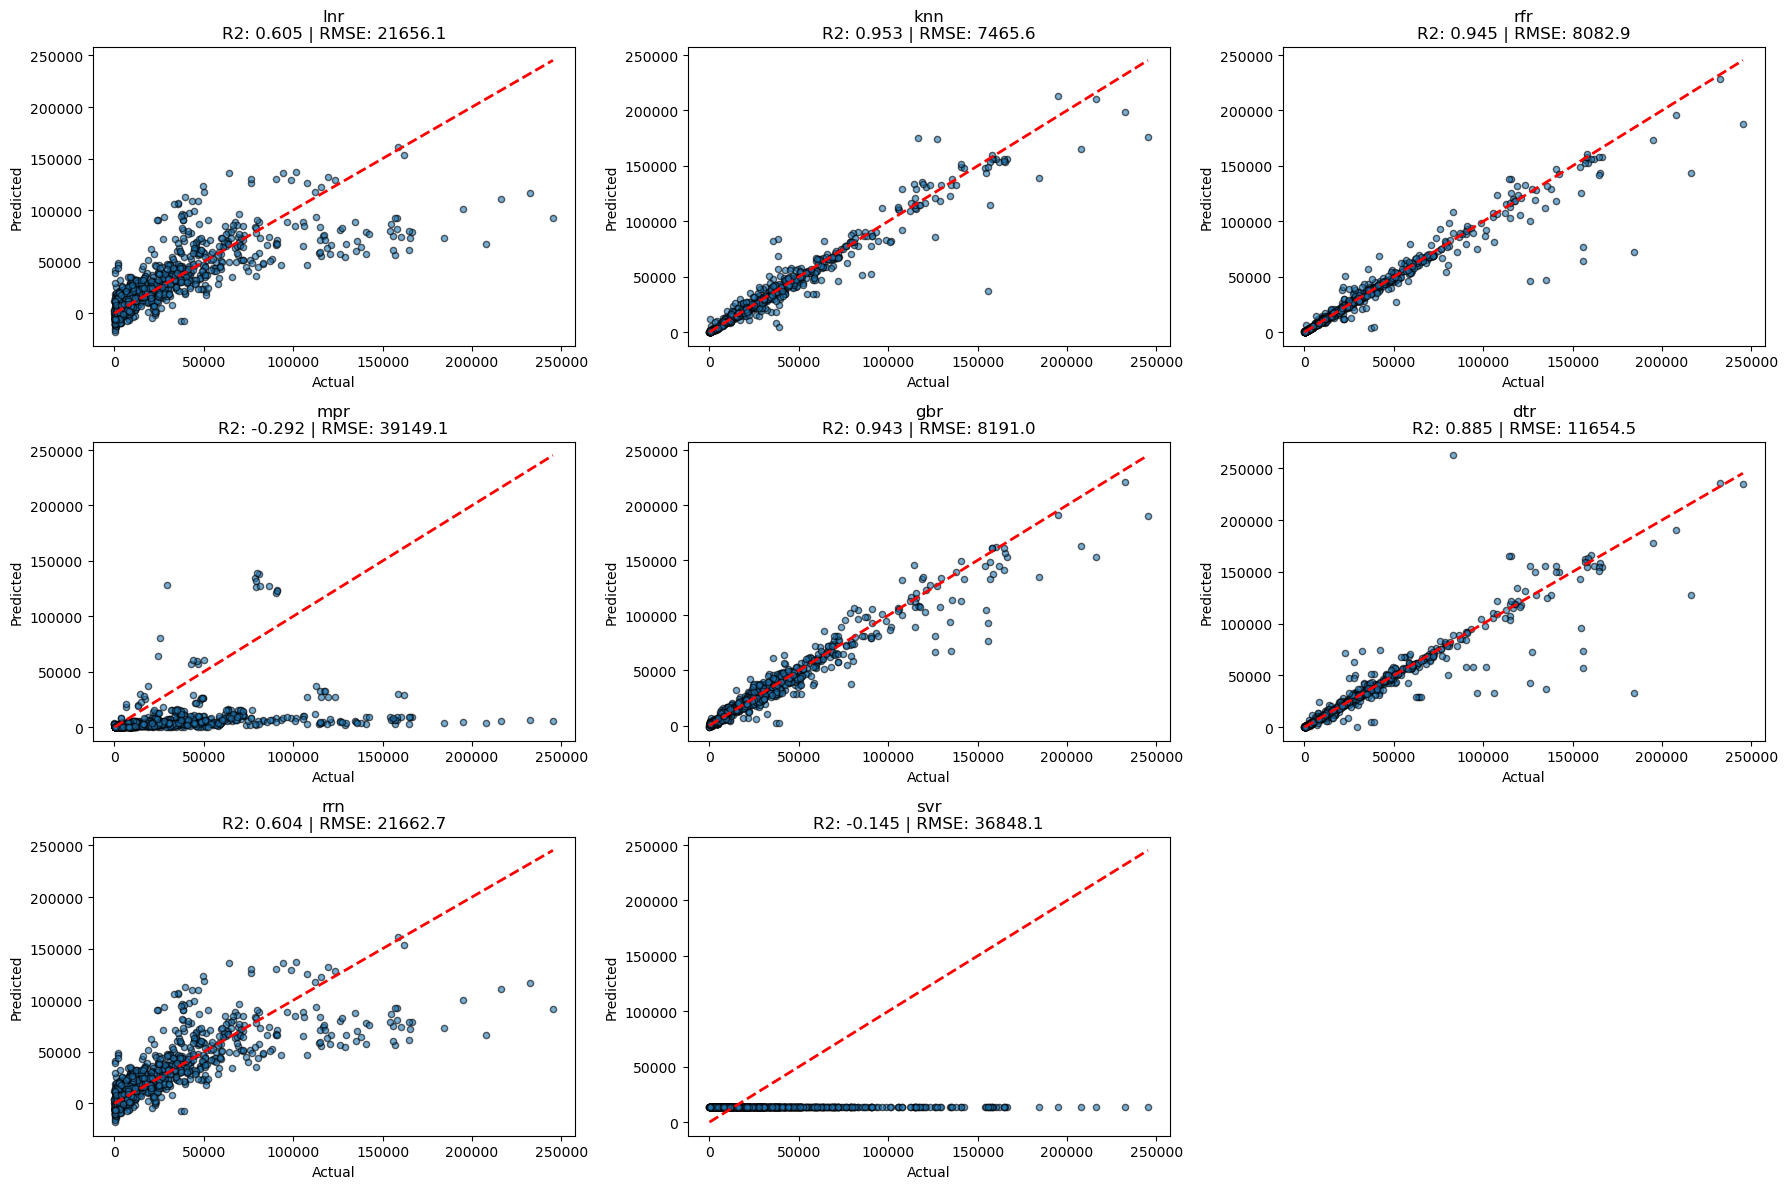

In [50]:
plt.figure(figsize=(18,12))

for i,n in enumerate(models, start=1):
    models[n].fit(X_train_scaled, y_train)
    y_pred= models[n].predict(X_test_scaled)

    r2= r2_score(y_test, y_pred)
    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae= mean_absolute_error(y_test, y_pred)

    plt.subplot(3,3,i)
    plt.scatter(y_test,y_pred, alpha=0.6, edgecolors='k', s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'{n}\nR2: {r2:.3f} | RMSE: {rmse:.1f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

In [51]:
rfr= RandomForestRegressor().fit(X_train, y_train)
print(f'Accuracy: {rfr.score(X_test, y_test):.3f}')

Accuracy: 0.945


In [63]:
from sklearn.model_selection import GridSearchCV
kfp= KFold(n_splits=3, shuffle=True, random_state=42)

best_hyp= {}

hyp_grid = {
    'lnr': {'copy_X': [True, False], 'fit_intercept': [True, False]},
    'knn': {'leaf_size': [5, 10], 'n_neighbors': [20, 50], 'weights': ['uniform', 'distance']},
    'dtr': {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]},
    'rfr': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'gbr': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
    'mpr': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['tanh', 'relu']},
    'svr': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}
for n in hyp_grid:
    grid_search= GridSearchCV(
        estimator= models[n],
        param_grid= hyp_grid[n],
        cv= kfp,
        scoring='r2',
        n_jobs= -1
    )

    grid_search.fit(X_train_scaled, y_train)
    best_hyp[n]= grid_search.best_params_

    print(f'{n} Best CV Score: {grid_search.best_score_:.3%}')

models_tuned= {
    'lnr' :LinearRegression(**best_hyp['lnr']),
    'knn' :KNeighborsRegressor(**best_hyp['knn']),
    'rfr' :RandomForestRegressor(**best_hyp['rfr']),
    'mpr' :MLPRegressor(**best_hyp['mpr']),
    'gbr' :GradientBoostingRegressor(**best_hyp['gbr']),
    'dtr' :DecisionTreeRegressor(**best_hyp['dtr']),
    'rrn' :Ridge(alpha=10),
    'svr' :SVR(**best_hyp['svr'])
}


lnr Best CV Score: 64.910%
knn Best CV Score: 88.957%
dtr Best CV Score: 95.141%
rfr Best CV Score: 97.263%
gbr Best CV Score: 95.934%


c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mpr Best CV Score: -33.367%
svr Best CV Score: 41.624%


In [68]:
final_result= []

for name, model in models_tuned.items():
    model.fit(X_train_scaled, y_train)
    y_pred= model.predict(X_test_scaled)

    r2= r2_score(y_test, y_pred)
    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    final_result.append({
        'Model': name,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })

final_df= pd.DataFrame(final_result)
final_df

c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,R2 Score,MAE,RMSE
0,lnr,0.604559,13061.132089,21656.052123
1,knn,0.919129,4598.603622,9793.425243
2,rfr,0.948465,2351.633240,7817.855965
3,mpr,-0.289808,22815.602835,39111.156607
4,gbr,0.943247,4062.181400,8204.125054
5,dtr,0.888435,2988.548992,11502.765932
6,rrn,0.604315,12997.322263,21662.724232
7,svr,0.453844,11992.280733,25450.507446


c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


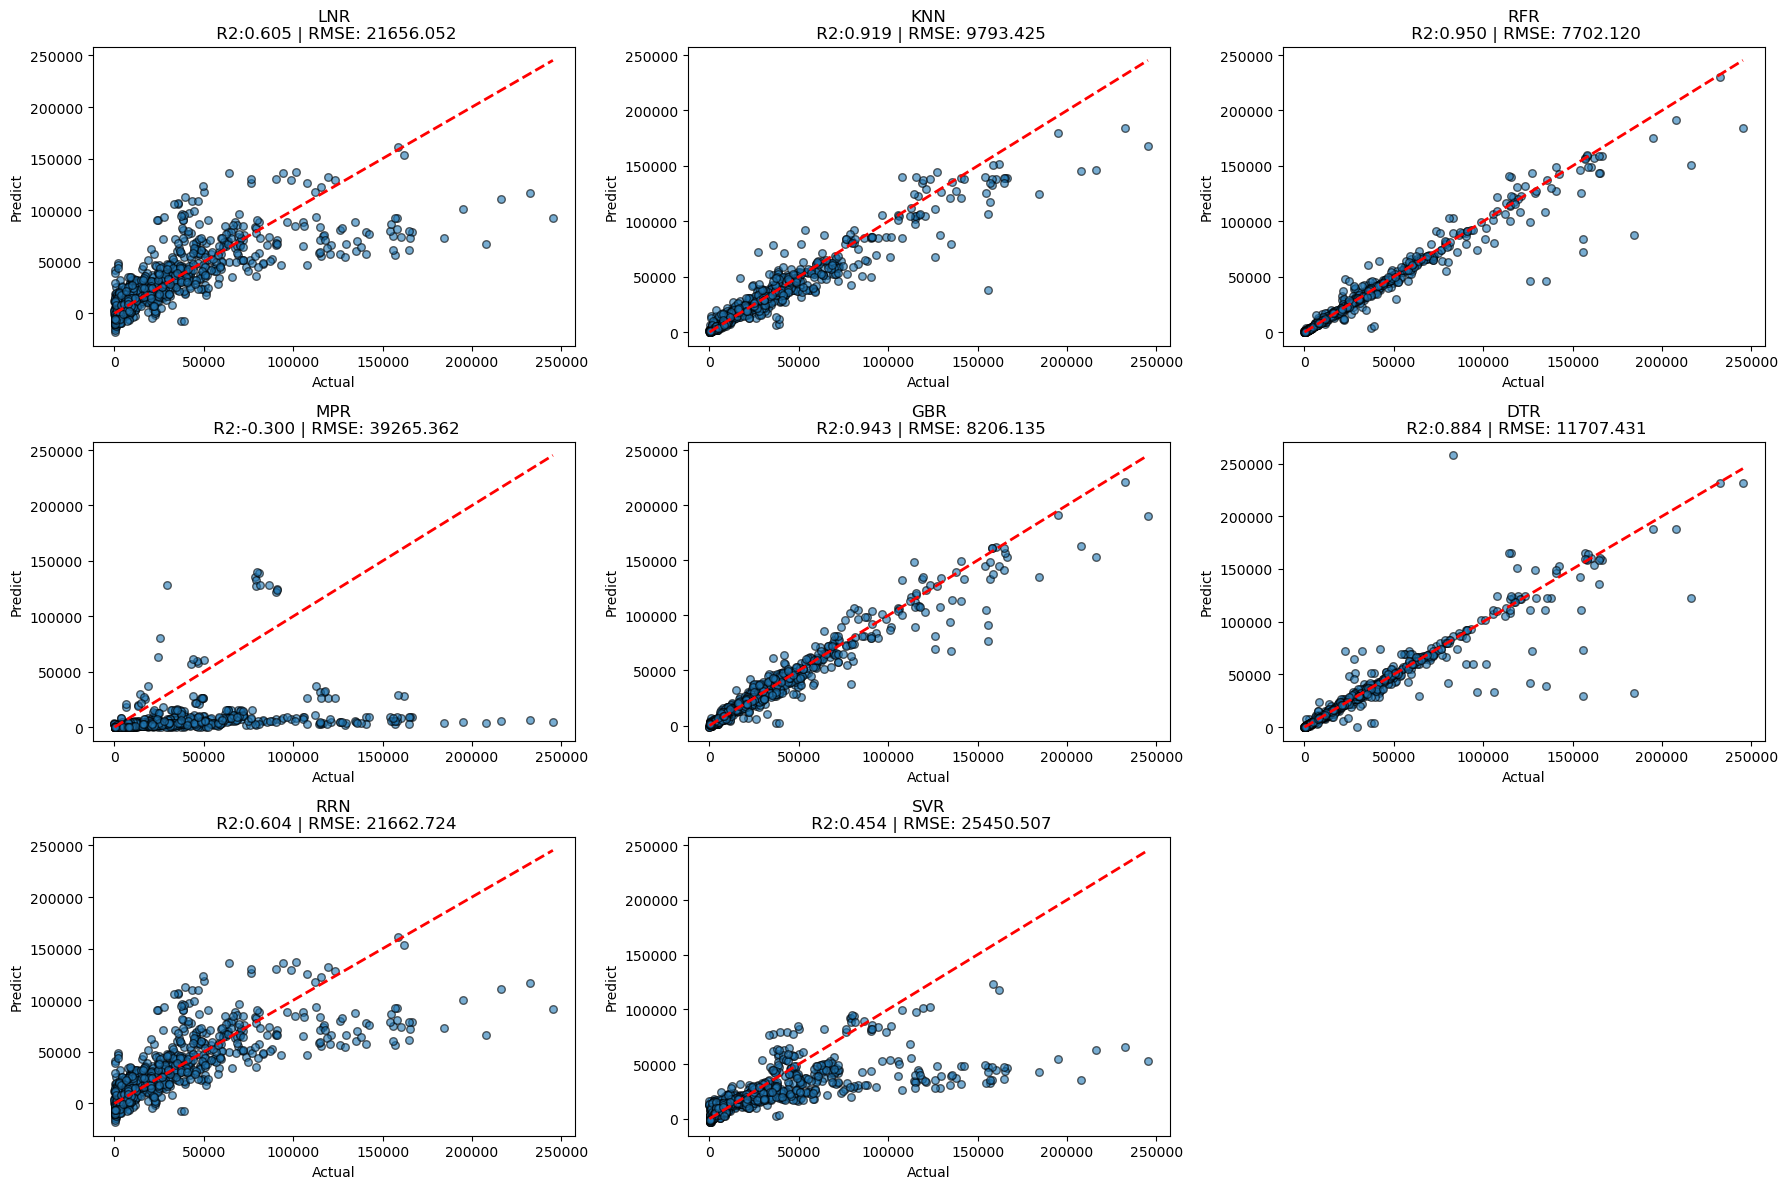

In [70]:
plt.figure(figsize= (18,12))

final_comparison= []

for i, n in enumerate(models_tuned, start=1):
    models_tuned[n].fit(X_train_scaled, y_train)
    y_pred= models_tuned[n].predict(X_test_scaled)

    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae= mean_absolute_error(y_test, y_pred)
    score= models_tuned[n].score(X_test_scaled, y_test)

    final_comparison.append({
        'Model': n,
        'R2': score,
        'RMSE': rmse,
        'MAE': mae
    })

    plt.subplot(3,3,i)
    plt.scatter(y_test, y_pred, alpha= 0.6, edgecolors= (0,0,0), s=30)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predict')
    plt.title(f'{n.upper()}\n R2:{score:.3f} | RMSE: {rmse:.3f}')

plt.tight_layout()
plt.show()